In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys
import os
import logging
sys.path.append("/usr/wrk/people9/sima9999/code/")
sys.path.append("/vegas/users/staff/womo1998/Projects/2019_OMA_UQ/code/")
import matplotlib
# a bug in jupyter / ipympl / matplotlib needs this here when using %maptlotlib widget
# somehow rc_context is broken in that case
matplotlib.rc('text.latex', preamble=r"\usepackage{siunitx}\usepackage{xfrac}\usepackage{amssymb, amsfonts}")
# to adjust figure uncomment here and comment out %matplotlib widget, restart kernel and 
# make sure jupyterlab is running in a x-forwarded and connected ssh session and the right display is set
# os.environ['DISPLAY'] = 'localhost:17.0'
# matplotlib.use("qtagg")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from uncertainty.polymorphic_uncertainty import *
from helpers import get_pcd

%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas - scipy.stats -scipy.stats.qmc -ray

In [2]:
from examples.UQ_Modal_Beam import mapping_function, vars_definition, est_imp, opt_inc

In [3]:
vars_ale, vars_epi, arg_vars = vars_definition()
dim_ex = 'cartesian'

# %%snakeviz
N_mcs_ale = 13717 # N_mcs = 1e6 = N_mcs_ale * N_mcs_epi
N_mcs_epi = 729 # = 3^6 = 2.56^n_imp ~ 3^n_imp -> cover every corner and midpoints in a full-factorial design (but distributed)
use_dm = True
result_dir = '/usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/'

In [4]:
ret_name = ['damp_freqs','zetas','frf'][0]
if ret_name == 'frf':
    ret_ind = {'frequencies':105, 'space':2}
else:
    ret_ind = {'modes':7}
ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
samp_path = os.path.join(result_dir,'polyuq_samp.npz')
prop_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz')

poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
poly_uq.load_state(samp_path, differential='samp')
poly_uq.load_state(prop_path, differential='prop')

INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/polyuq_samp.npz
INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/damp_freqs-7/polyuq_prop.npz


### Considerations

we have a matrix of input samples N_mcs_ale x n_vars_ale, N_mcs_epi x n_vars_epi
we have a matrix of output samples N_mcs_ale x N_mcs_epi x 1

#### choices:

1) compute sensitivities for vars_ale and vars_epi separately for selected samples of the other kind, respectively -> allows second-order effects?
2) compute sensitivities from the diagonal of the output matrix -> following regular qMCS sampling
3) flatten outputs and compute sensitivities -> would problems appear due to repetition of values?
    - might even be good for bootstrapping

#### first-order sensitivity:
compute variance of output

- for each variable:
    - argsort input samples
    - subdivide output and input samples into s subdivisions
    - for each subdivision:
        - compute mean
    - compute variance of mean -> first-order sensitivity 
    - error/confidence measure? -> use the bootstrap method
    

#### total-order sensitivity
compute mean over all but one input

- fix all but one input 
    - grouping into n-1 dimensional hypercubes, that capture the variance of input j but other inputs remain relatively constant (not possible from existing samples)
    - compute variance

Develop it on a Sobol's g-function and verify it on the Ishigami function, then transfer it to polyuq

- define the functions as python functions
- generate and propagate qMC samples and regular MC samples
- write a function for variance based sensi
- verify and validate
- (implement density based sensi)
- generate sample lattices as in polyuq and test different options for choosing samples
- transfer to polyuq
- implement confidence bounds with the bootstrap method

### Implementaiton

In [123]:
import scipy.stats.qmc
import scipy.stats
import numpy as np
import SALib
from SALib.analyze import delta as delta

In [118]:
def sobol_g(X, a):
    num_samples, num_params = X.shape
    assert len(a) == num_params
    Y = np.ones((num_samples,))
    for k in range(num_params):
        Y *= (np.abs(4 * X[:,k] - 2) + a[k])/(1 + a[k])
    return Y

def sobol_g_S_an(a):
    num_params = a.shape[0]
    denom = 1
    for k in range(num_params):
        beta = 1 / 3 * (1 + a[k])**(-2)
        denom *= (1 + beta)
    denom -= 1
    S_an = np.empty((num_params,))
    for k in range(num_params):
        beta = 1 / 3 * (1 + a[k])**(-2)
        S_an[k] = beta / denom
    return S_an

def ishigami(X, a):
    return np.sin(X[:,0]) + a[0] * np.sin(X[:,1])**2 + a[1] * X[:,2]**4 * np.sin(X[:,0])

def ishigami_S_an(a):
    V = np.full((3,), 1 / (a[0]**2 / 8 + a[1] * np.pi**4 / 5 + a[1]**2 * np.pi**8 / 18 + 1 / 2))
    V[0] *= a[1] * np.pi**4 / 5 + a[1]**2 * np.pi**8 / 50 + 1 / 2
    V[1] *= a[0]**2 / 8
    V[2]  = 0
    return V
    

In [119]:
def estimate_first_order_sens(x, y, num_subdivisions=None):
    num_samples, num_params = x.shape
    if num_subdivisions is None:
        # taken from SALib.analyze.delta
        exp = 2.0 / (7.0 + np.tanh((1500.0 - num_samples) / 500.0))
        num_subdivisions = int(np.round(min(int(np.ceil(num_samples**exp)), 48)))
        # print(f'Using {num_subdivisions} subdivisions')
    S = np.full((num_params,), 1/np.var(y))
    n_per_s = num_samples // num_subdivisions
    # print(f'Remaining {num_samples % num_subdivisions} samples will be discarded.')
    for k in range(num_params):
        sort_ind = np.argsort(x[:,k])
        # xk_sort = x[sort_ind,k]
        y_sort = y[sort_ind]
        means = np.empty((num_subdivisions,))
        for s in range(num_subdivisions):
            means[s] = np.mean(y_sort[s * n_per_s:(s + 1) * n_per_s])
        S[k] *= np.var(means)
    return S

In [120]:
if True:
    num_params = 10
    a = np.random.random((num_params,))
    # a = [0,0.9,99.9]
    obj_fun = sobol_g
    an_fun = sobol_g_S_an
else:
    num_params = 3
    a = np.random.random((num_params,))
    obj_fun = ishigami
    an_fun = ishigami_S_an
problem = {'num_vars': num_params, 'names': [f'x{k}' for k in range(num_params)]}
print(an_fun(a))

[0.05984846 0.04003667 0.05321631 0.0206806  0.04033321 0.06238067
 0.0339351  0.03911446 0.0252149  0.0395554 ]


In [6]:
N_mcs = 732
engine = scipy.stats.qmc.Halton(num_params)
X = engine.random(N_mcs)
if obj_fun == ishigami:
    X -= 0.5
    X *= 2*np.pi

Y = obj_fun(X,a)

In [121]:
# assume 2 ale params, remaining epi
N_mcs_epi = 729
N_mcs_ale = 13717
engine = scipy.stats.qmc.Halton(num_params)
X_gen = engine.random(max(N_mcs_epi, N_mcs_ale))
if obj_fun == ishigami:
    X_gen -= 0.5
    X_gen *= 2*np.pi

X_lat = np.empty((N_mcs_ale, N_mcs_epi, num_params))

for var_ale in range(2):
    X_lat[:,:,var_ale] = np.repeat(X_gen[:N_mcs_ale,var_ale:var_ale + 1],N_mcs_epi,1)
for var_epi in range(2, num_params):
    X_lat[:,:,var_epi] = np.repeat(X_gen[:N_mcs_epi,var_epi:var_epi + 1].T,N_mcs_ale,0)
# display(X_lat[0,0,:])
# display(X_lat[0,1,:])
# display(X_lat[0,2,:])
X_lat_flat = X_lat.reshape((N_mcs_ale*N_mcs_epi, num_params)) # appends rows to each other
# display(X_lat[-1,-3,:])
# display(X_lat[-1,-2,:])
# display(X_lat[-1,-1,:])
Y_lat_flat = obj_fun(X_lat_flat, a)

In [42]:
if False: #diagonal selection
    ind = np.eye(N_mcs_ale, N_mcs_epi, dtype=bool).reshape((N_mcs_ale*N_mcs_epi,))
    X = X_lat_flat[ind,:]
    Y = Y_lat_flat[ind]
elif False: # select all, flat; only variance-based is fast enough for this
    X = X_lat_flat
    Y = Y_lat_flat
elif True: # select a random subset (with replacement)
    N_mcs_min = min(N_mcs_ale, N_mcs_epi)
    ind = np.random.choice(np.arange(Y_lat_flat.size),N_mcs_min,)
    X = X_lat_flat[ind,:]
    Y = Y_lat_flat[ind]

In [68]:
S = estimate_first_order_sens(X,Y)
S_an = an_fun(a)

Using 6 subdivisions
Remaining 0 samples will be discarded.


In [124]:
SA_S = delta.analyze(problem, X, Y)
SA_S

NameError: name 'X' is not defined

(0.0, 1.0)

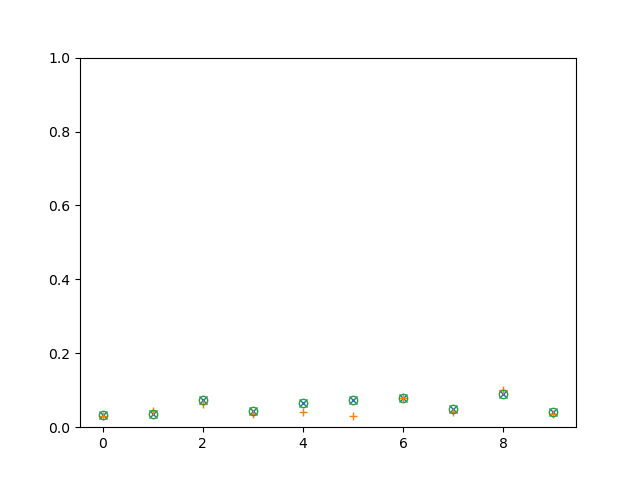

In [65]:
plt.figure()
plt.plot(S, ls='none',marker='x')
plt.plot(S_an, ls='none',marker='+')
plt.plot(SA_S['S1'], ls='none',marker='o',fillstyle='none')
plt.ylim((0,1))

### Convergence study

- define the MAE for both measures (sum of absolute difference)
- Generate the convergence for increasing N_mcs (in both dimensions with variable ale-to-epi-ratio) N_mcs = 2**n (n=8...15)
- Consider cases: different test functions/num_params, different re-sampling strategies,  

In [109]:
def MAE(choice,meth,):
    problem = {'num_vars': num_params, 'names': [f'x{k}' for k in range(num_params)]}
    all_n = np.arange(8,15)
    # MAE_V = np.empty((all_n.size,))
    # MAE_D = np.empty((all_n.size,))
    MAE = np.empty((all_n.size,))
    n_ind = np.arange(all_n.size)
    np.random.shuffle(n_ind)
    for i in n_ind:
        n = all_n[i]             
        N_mcs = 2**n
        
        #assuming some random ratio of epistemic to aleatory samples
        ea_rat = np.random.random(1) + 1
        if choice==2:
            N_mcs_epi = int(np.sqrt(N_mcs / ea_rat))
            N_mcs_ale = int(np.sqrt(ea_rat * N_mcs))
        else:
            N_mcs_epi = N_mcs
            N_mcs_ale = int(ea_rat * N_mcs)
        
        engine = scipy.stats.qmc.Halton(num_params)
        X_gen = engine.random(max(N_mcs_epi, N_mcs_ale))
        if obj_fun == ishigami:
            X_gen -= 0.5
            X_gen *= 2 * np.pi
        
        X_lat = np.empty((N_mcs_ale, N_mcs_epi, num_params), dtype=np.float32)

        # assume 2 ale params, remaining epi
        for var_ale in range(2):
            X_lat[:,:,var_ale] = np.repeat(X_gen[:N_mcs_ale,var_ale:var_ale + 1],N_mcs_epi,1)
        for var_epi in range(2, num_params):
            X_lat[:,:,var_epi] = np.repeat(X_gen[:N_mcs_epi,var_epi:var_epi + 1].T,N_mcs_ale,0)
        X_lat_flat = X_lat.reshape((N_mcs_ale*N_mcs_epi, num_params)) # appends rows to each other
        # Y_lat_flat = obj_fun(X_lat_flat, a)
        if choice==1: #diagonal selection
            ind = np.eye(N_mcs_ale, N_mcs_epi, dtype=bool).reshape((N_mcs_ale*N_mcs_epi,))
            X = X_lat_flat[ind,:]
            # Y = Y_lat_flat[ind]
        elif choice==2: # select all, flat; only variance-based is fast enough for this
            X = X_lat_flat
            # Y = Y_lat_flat
        elif choice==3: # select a random subset (with replacement)
            N_mcs_min = min(N_mcs_ale, N_mcs_epi)
            ind = np.random.choice(np.arange(X_lat_flat.shape[0]),N_mcs_min,)
            X = X_lat_flat[ind,:]
            # Y = Y_lat_flat[ind]
        Y = obj_fun(X, a)
        S_an = an_fun(a)
        
        if meth=='var':
            S = estimate_first_order_sens(X,Y)
        elif meth=='dens':
            S = delta.analyze(problem, X, Y)['S1']
        
        MAE[i] = np.mean(np.abs(S - S_an))
    return choice, meth, MAE

In [83]:
import ray

In [110]:
ray.shutdown()
ray.init(address='auto', _redis_password='5241590000000000')
futures1 = []
remote_MAE = ray.remote(num_cpus=4, )(MAE)

2023-06-15 09:54:00,778	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 141.24.193.47:6379...
2023-06-15 09:54:00,782	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at 141.24.193.47:5990 


In [111]:
for choice in [1,2,3]:
    for meth in ['var','dens']:
        for i in range(30):
            futures1.append(remote_MAE.remote(choice,meth))        

In [112]:
MAE_dens_1 = []
MAE_dens_2 = []
MAE_dens_3 = []
MAE_var_1 = []
MAE_var_2 = []
MAE_var_3 = []

In [ ]:
### run that for sobol-g 10, sobol-g 3, ishigami

futures = set(futures1)
while True:
    ready, wait = ray.wait(
        list(futures), num_returns=min(len(futures), 10), timeout=60)
    finished = []
    failed = []
    for obj_ref in ready:
        try:
            choice, meth, thisMAE = ray.get(obj_ref)
            if meth=='dens':
                all_MAE = [None,MAE_dens_1,MAE_dens_2,MAE_dens_3][choice]
            elif meth=='var':
                all_MAE = [None,MAE_var_1,MAE_var_2,MAE_var_3][choice]
            else:
                raise RuntimeErrror
            all_MAE.append(thisMAE)
            finished.append(obj_ref)
        except ray.exceptions.RayTaskError as e:
            print(e)
            failed.append(obj_ref)
    
    size_before = len(futures)
    futures.difference_update(finished)
    futures.difference_update(failed)
    print(f"Finished {len(finished)}, failed {len(failed)} samples. Remaining {len(futures)} samples. (before {size_before})")
        
    if len(futures) == 0:
        break

In [128]:
mean_MAE_dens_1 = np.mean(np.array(MAE_dens_1), axis=0)
mean_MAE_dens_2 = np.mean(np.array(MAE_dens_2), axis=0)
mean_MAE_dens_3 = np.mean(np.array(MAE_dens_3), axis=0)
mean_MAE_var_1 = np.mean(np.array(MAE_var_1), axis=0)
mean_MAE_var_2 = np.mean(np.array(MAE_var_2), axis=0)
mean_MAE_var_3 = np.mean(np.array(MAE_var_3), axis=0)

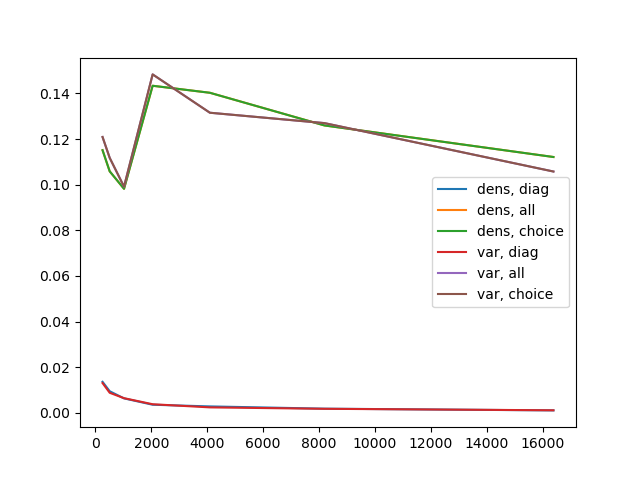

In [131]:
plt.figure()
x = 2**np.arange(8,15)
plt.plot(x,mean_MAE_dens_1, label='dens, diag')
plt.plot(x,mean_MAE_dens_2, label='dens, all')
plt.plot(x,mean_MAE_dens_2, label='dens, choice')
plt.plot(x,mean_MAE_var_1, label='var, diag')
plt.plot(x,mean_MAE_var_2, label='var, all')
plt.plot(x,mean_MAE_var_2, label='var, choice')
plt.legend()

In [140]:
mean_MAE_dens_3, mean_MAE_var_3, mean_MAE_dens_2, mean_MAE_var_2

(array([0.02133666, 0.01324225, 0.00978389, 0.00879308, 0.00572152,
        0.00358686, 0.00267338]),
 array([0.02257467, 0.01333346, 0.00909559, 0.00842897, 0.00608477,
        0.00386733, 0.00285603]),
 array([0.11513848, 0.10586967, 0.09821246, 0.14339182, 0.14031351,
        0.12599564, 0.11215172]),
 array([0.12092784, 0.11177337, 0.09914327, 0.14837336, 0.13156474,
        0.12701594, 0.10578707]))

### Confidence

In [125]:
Nr = 4096

def bootstr_wrap(ind):
    ind = np.random.randint(0, Y_lat_flat.shape[0], Nr)
    X = X_lat_flat[ind,:]
    Y = Y_lat_flat[ind]
    return estimate_first_order_sens(X,Y)

In [231]:
res = scipy.stats.bootstrap(np.arange(Nr)[np.newaxis,:], bootstr_wrap, vectorized=False)
ind = np.random.randint(0, Y_lat_flat.shape[0], Nr)
S1_ = estimate_first_order_sens(X_lat_flat[ind,:],Y_lat_flat[ind])

In [129]:
# SA_S = delta.analyze(problem, X_lat_flat, Y_lat_flat, y_resamples=100, method='all')
np.savetxt('/dev/shm/womo1998/X.txt',X_lat_flat)
np.savetxt('/dev/shm/womo1998/Y.txt',Y_lat_flat)
# SA_S

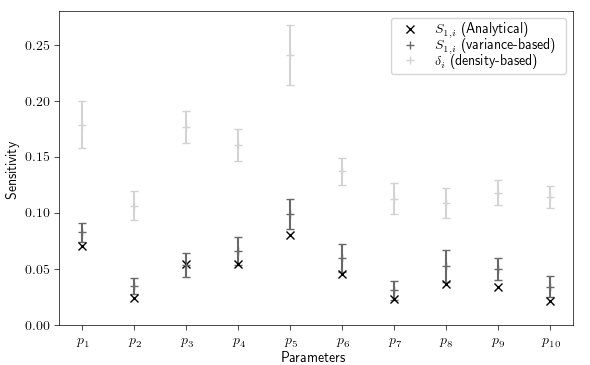

In [239]:
# S1_ = S1
with matplotlib.rc_context(get_pcd('print')):
    plt.figure()
    handles = []
    S1 =(res.confidence_interval.high+res.confidence_interval.low)/2
    # plt.plot(np.arange(num_params)-0.15, S1_,marker='x', ls='none', color='red'
    #         )
    eb_cont = plt.errorbar(np.arange(num_params), S1, [S1-res.confidence_interval.low,res.confidence_interval.high-S1], 
                           marker='+', ls='none', capsize=3, label='$S_{1,i}$ (variance-based)', color='dimgrey')
    eb_cont = plt.errorbar(np.arange(num_params),SA_S['delta'], SA_S['delta_conf'], 
                           marker='+', ls='none', capsize=3, label='$\delta_i$ (density-based)', color='lightgrey')
    # eb_cont = plt.errorbar(np.arange(num_params)+0.15,SA_S['S1'], SA_S['S1_conf'], 
    #                        marker='x', ls='none', capsize=3, label='$\S_{1,i}$ (density-based)', color='lightgrey')
    lines = plt.plot(np.arange(num_params),an_fun(a), ls='none', 
                     marker='x', fillstyle='none', label='$S_{1,i}$ (Analytical)', color='black')
    # get handles
    handles, labels = plt.gca().get_legend_handles_labels()
    # remove the errorbars
    handles = [h[0] if isinstance(h, tuple) else h for h in handles]
    # use them in the legend
    plt.gca().legend(handles, labels)#, loc='upper left',numpoints=1)
    plt.gca().set_xticks(np.arange(num_params), [f'$p_{{{i+1}}}$' for i in range(num_params)])
    plt.ylim(ymin=0)
    plt.xlabel('Parameters')
    plt.ylabel('Sensitivity')
    plt.subplots_adjust(top=0.97,bottom=0.11, left=0.1, right=0.97)
    # plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/uncertainty/ex_sensi_conf_k10.png')
    # plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/uncertainty/ex_sensi_conf_k10.pdf')

How to proceed from here? What do we need for the thesis?
- Convergence Study is in the papers and the choice of a sample selection method is deemed a minor detail, which must not be proven by a convergence study
- An example with sobol-g 10 parameters, showing confidence intervals with variance-based, from density based and analytical results

- port the methods to PolyUQ
- run Sensi for uq_modal_beam and include confidence intervals as a table in the journalpaper (not another graph)

<AxesSubplot: >

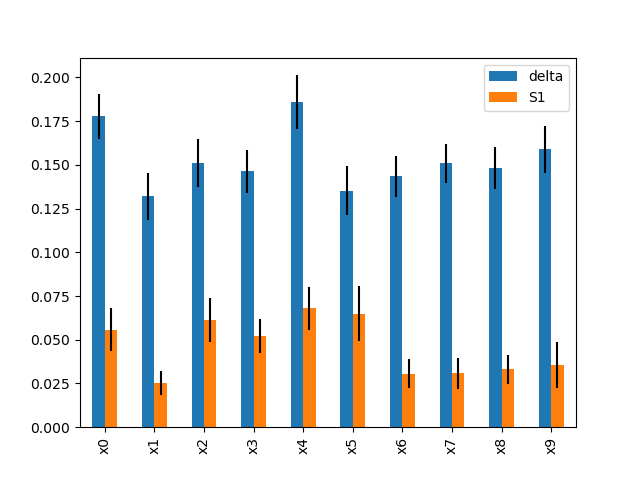

In [248]:
ind = np.random.randint(0, Y_lat_flat.shape[0], Nr)
SA_S = delta.analyze(problem, X_lat_flat[ind,:], Y_lat_flat[ind], y_resamples=Nr, method='all')
SA_S.plot()

<AxesSubplot: >

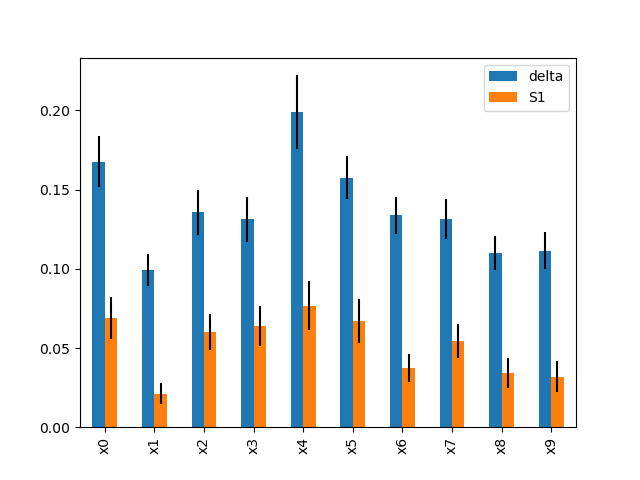

In [254]:
ind = np.random.randint(0, Y_lat_flat.shape[0], 4*Nr)
SA_S = delta.analyze(problem, X_lat_flat[ind,:], Y_lat_flat[ind], y_resamples=Nr, method='all')
SA_S.plot()

<AxesSubplot: >

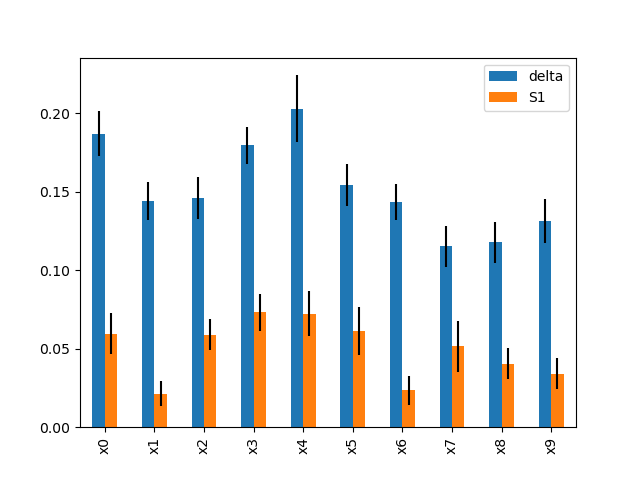

In [253]:
ind = np.random.randint(0, Y_lat_flat.shape[0], 4*Nr)
SA_S = delta.analyze(problem, X_lat_flat[ind,:], Y_lat_flat[ind], y_resamples=Nr, method='all')
SA_S.plot()

In [182]:
SA_S = delta.analyze(problem, X_lat_flat, Y_lat_flat, y_resamples=100)
SA

NameError: name 'SA' is not defined

### PolyUQ Integration

In [38]:
logger= logging.getLogger('uncertainty.polymorphic_uncertainty')
logger.setLevel(level=logging.DEBUG)
res = poly_uq.estimate_sensi('var', y_resamples=10000)
display(res)

INFO:uncertainty.polymorphic_uncertainty:Estimating  var-based sensitivity indices with rand sample selection and 10000 samples for bootstrapping with None resamples...
DEBUG:uncertainty.polymorphic_uncertainty:Shapes: X (9999693, 9), Y (9999693,), y_resamples 10000, N_mcs_ale 13717, N_mcs_epi 729
DEBUG:uncertainty.polymorphic_uncertainty:Using 22 subdivisions
DEBUG:uncertainty.polymorphic_uncertainty:Remaining 12 samples will be discarded.
....................................................................................................


(array([0.10666687, 0.0010878 , 0.56685975, 0.0184452 , 0.00897471,
        0.24364059, 0.00704051, 0.00334004, 0.61001253]),
 [array([ 9.63642953e-02, -1.76998118e-04,  5.52110444e-01,  1.14931084e-02,
          5.69414712e-03,  2.30072735e-01,  3.86864401e-03,  1.22745397e-03,
          5.98937365e-01]),
  array([0.11696944, 0.00235259, 0.58160906, 0.0253973 , 0.01225526,
         0.25720845, 0.01021239, 0.00545262, 0.6210877 ])],
 ['N_wire',
  'dD',
  'ice_occ',
  'b',
  't',
  'add_mass',
  'A_wire',
  'zeta',
  'ice_mass'])

In [142]:
# poly_uq.save_state(os.path.join(result_dir,'polyuq_sens_var.npz'), differential='sensi')
poly_uq.load_state(os.path.join(result_dir,'estimations', f'{ret_dir}/polyuq_sens_var.npz'), differential='sensi')
print(poly_uq.S_point, poly_uq.S_conf, poly_uq.S_meth)
display(res)

INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/zetas-9/polyuq_sens_var.npz
[ 9.38334652e-04  1.12869421e-02  6.19234673e-04  1.72725299e-02
  5.94816372e-03  1.62162909e-02  8.47291383e-03  9.87716160e-01
 -4.02455247e-04] [[-4.59347586e-04  7.85250582e-03 -7.03137537e-04  1.04379601e-02
  -1.36717193e-04  1.02080744e-02  5.13637406e-04  9.87334706e-01
  -4.92531088e-03]
 [ 2.33601689e-03  1.47213784e-02  1.94160688e-03  2.41070998e-02
   1.20330446e-02  2.22245075e-02  1.64321903e-02  9.88097613e-01
   4.12040039e-03]] var


(array([0.10666687, 0.0010878 , 0.56685975, 0.0184452 , 0.00897471,
        0.24364059, 0.00704051, 0.00334004, 0.61001253]),
 [array([ 9.63642953e-02, -1.76998118e-04,  5.52110444e-01,  1.14931084e-02,
          5.69414712e-03,  2.30072735e-01,  3.86864401e-03,  1.22745397e-03,
          5.98937365e-01]),
  array([0.11696944, 0.00235259, 0.58160906, 0.0253973 , 0.01225526,
         0.25720845, 0.01021239, 0.00545262, 0.6210877 ])],
 ['N_wire',
  'dD',
  'ice_occ',
  'b',
  't',
  'add_mass',
  'A_wire',
  'zeta',
  'ice_mass'])

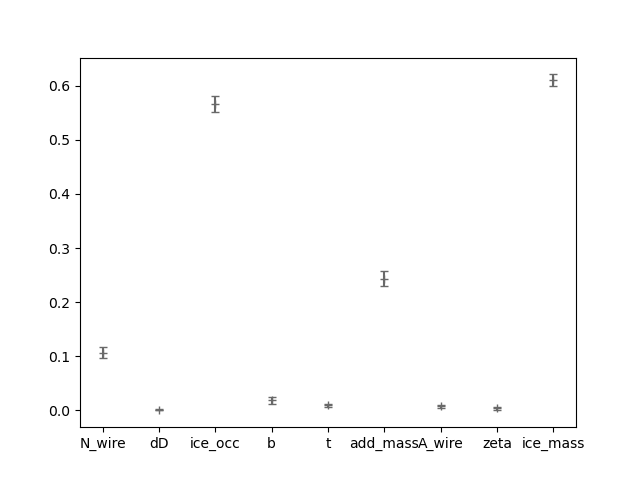

In [143]:
plt.figure()
S1 = res[0]
plt.errorbar(np.arange(len(res[2])), S1, [S1 - res[1][0], res[1][1] - S1], 
                           marker='+', ls='none', capsize=3, label='$S_{1,i}$ (variance-based)', color='dimgrey')
plt.gca().set_xticks(np.arange(len(res[2])), res[2])

In [33]:
res = poly_uq.estimate_sensi('dens', y_resamples=10000)

DEBUG:uncertainty.polymorphic_uncertainty:Shapes: X (9999693, 9), Y (9999693,), Nr 10000, N_mcs_ale 13717, N_mcs_epi 729


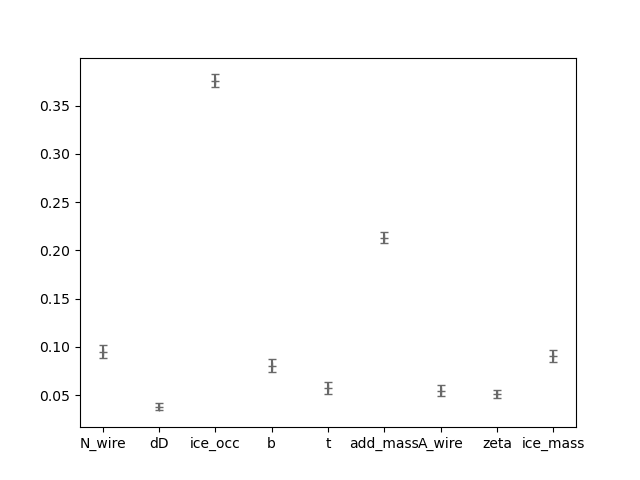

In [34]:
plt.figure()
S1 = res[0]
plt.errorbar(np.arange(len(res[2])), S1, [S1-res[1][0],res[1][1]-S1], 
                           marker='+', ls='none', capsize=3, label='$S_{1,i}$ (variance-based)', color='dimgrey')
plt.gca().set_xticks(np.arange(len(res[2])), res[2])
None

Ok that seems to be working and we get plausible results. Now whats next:
- look at the other quantities
    - side by side or stacked bar plot /w all 14  sensititivies (per output quantity)
    - heatmap out quant vs. parameters (Si could be color, confidence could be alpha encoded)
- for the paper, 
    - we don't want another graph, or maybe we should have one?
    - prefer tabular or aggregated data
    - ...?
- for the thesis
    - write up more details about SA?!
    - use the top graphs in the uq_modal_beam example



In [42]:
def sensi(result_dir, ret_name, ret_ind, meth, Nr):
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
    samp_path = os.path.join(result_dir,'polyuq_samp.npz')
    prop_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz')

    poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
    poly_uq.load_state(samp_path, differential='samp')
    poly_uq.load_state(prop_path, differential='prop')

    poly_uq.estimate_sensi(meth, y_resamples=Nr)
    poly_uq.save_state(os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_sens_{meth}.npz'), differential='sens')

In [39]:
import ray

In [48]:
ray.shutdown()

In [44]:
ray.init(address='auto', _redis_password='5241590000000000')
futures = []
remote_sensit = ray.remote(num_cpus=1)(sensi)

2023-06-29 10:29:57,453	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 141.24.193.47:6379...
2023-06-29 10:29:57,457	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at 141.24.193.47:5990 


In [ ]:
ret_name = ['damp_freqs','zetas','frf'][1]

y_resamples=10000
if ret_name == 'frf':
    inds = range(10*3)
else:
    inds = range(14)
    
for meth in ['var', 'dens']:
    for ind in inds:
        if ret_name == 'frf':
            ret_ind = {'frequencies':ind//3, 'space':ind%3}
            if ind%3==0:
                continue
        else:
            ret_ind = {'modes':ind}
        robj = remote_sensit.remote(result_dir, ret_name, ret_ind, meth, y_resamples)

In [128]:
ret_name = ['damp_freqs','zetas','frf'][0:2]
meth='var'
if ret_name == 'frf':
    inds = range(10*3)
elif isinstance(ret_name, str):
    inds = range(14)
else:
    inds = range(10)
# plt.figure()

if isinstance(ret_name, str):
    ret_names = [ret_name]
else:
    ret_names = ret_name
    
S_point = np.empty((len(inds)*len(ret_names),9))
S_conf_intv = np.empty((len(inds)*len(ret_names),9))
names = []
for i,ret_name in enumerate(ret_names):
    for ind in inds:
        if ret_name == 'frf':
            ret_ind = {'frequencies':ind//3, 'space':ind%3}
            if ind%3==0:
                continue
        else:
            ret_ind = {'modes':ind}
        ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
        samp_path = os.path.join(result_dir,'polyuq_samp.npz')
        prop_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz')
        sens_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_sens_{meth}.npz')

        poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
        poly_uq.load_state(samp_path, differential='samp')
        poly_uq.load_state(prop_path, differential='prop')
        poly_uq.load_state(sens_path, differential='sens')

        S_point[i*len(inds)+ind,:] = poly_uq.S_point
        S_conf_intv[i*len(inds)+ind,:] = np.diff(poly_uq.S_conf, axis=0)
    names = list(poly_uq.inp_samp_prim.columns)
    
#     plt.errorbar(np.arange(len(names))+ind/15, S_point, [S_point-S_conf[0],S_conf[1]-S_point], 
#                            marker='+',markersize=1, ls='none', capsize=1, label=ret_dir)
# plt.gca().set_xticks(np.arange(len(names)), names)   
# remove Ice occurence
ind_I_occ = np.array(names)!='ice_occ'
S_point = S_point[:,ind_I_occ]
S_conf_intv = S_conf_intv[:,ind_I_occ]
names = np.array(names)[ind_I_occ]

INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/polyuq_samp.npz
INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/damp_freqs-0/polyuq_prop.npz
INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/damp_freqs-0/polyuq_sens_var.npz
INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/polyuq_samp.npz
INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/damp_freqs-1/polyuq_prop.npz
INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/damp_freqs-1/polyuq_sens_var.npz
INFO:uncertainty.polymorphic_uncertainty:Loading previous 

In [129]:
names = list(poly_uq.inp_samp_prim.columns)
    
#     plt.errorbar(np.arange(len(names))+ind/15, S_point, [S_point-S_conf[0],S_conf[1]-S_point], 
#                            marker='+',markersize=1, ls='none', capsize=1, label=ret_dir)
# plt.gca().set_xticks(np.arange(len(names)), names)   
# remove Ice occurence
ind_I_occ = np.array(names)!='ice_occ'
S_point = S_point[:,ind_I_occ]
S_conf_intv = S_conf_intv[:,ind_I_occ]
names = np.array(names)[ind_I_occ]

IndexError: boolean index did not match indexed array along dimension 1; dimension is 8 but corresponding boolean dimension is 9

In [ ]:
im_ratio = S_point.shape[1]/S_point.shape[0]
pcd = get_pcd('print')
pcd['figure.figsize'] = (pcd['figure.figsize'][0],pcd['figure.figsize'][0]*im_ratio)
with matplotlib.rc_context(pcd):
    plt.figure()
    S_conf_alpha = np.copy(S_conf_intv.T)/S_point.T
    S_conf_alpha /= S_conf_alpha.max()
    S_conf_alpha *= -1 
    S_conf_alpha += 1
    plt.imshow(S_point.T, 
               #alpha=S_conf_alpha, 
               vmin=0, vmax=1,
              cmap='Greys')
    plt.colorbar(fraction=0.0465*im_ratio, pad=0.04, label='Sensitivity $S_1$')
    if len(ret_names)>1:
        plt.gca().set_xticks(np.arange(2*len(inds)), [f'$f_{{{i+1}}}$' for i in range(len(inds))]+[f'$\zeta_{{{i+1}}}$' for i in range(len(inds))])
    elif ret_name == 'zetas':        
        plt.gca().set_xticks(np.arange(len(inds)), [f'$\zeta_{{{i+1}}}$' for i in range(len(inds))])
    elif ret_name == 'damp_freqs':
        plt.gca().set_xticks(np.arange(len(inds)), [f'$f_{{{i+1}}}$' for i in range(len(inds))])
    names_dict = {'N_wire':'$N_\mathrm{cbl}$',
                  'dD':'$d_\mathrm{D}$',
                  'ice_occ':'$\mathfrak{I}_\mathrm{occ}$',
                  'b':'$b$',
                  't':'$t$',
                  'add_mass':'$m_\mathrm{add}$',
                  'A_wire':'$A_\mathrm{cbl}$',
                  'zeta':'$\zeta_\mathrm{glob}$',
                  'ice_mass':'$\mathfrak{I}_\mathrm{m}$'}
    plt.gca().set_yticks(np.arange(len(names)), [names_dict[name] for name in names])   
    plt.xlabel('Output parameter')
    plt.ylabel('Input parameter')
    # plt.clabel('Sensivity')
    if len(ret_names)>1:
        plt.subplots_adjust(top=0.97, bottom=0.14, left=0.1, right=0.92)
        plt.axvline(len(inds)-0.5, c='k',lw=1)
        plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/sensi_matrix_all_{meth}.png')
        plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/sensi_matrix_all_{meth}.pdf')
    else:
        plt.subplots_adjust(top=0.97, bottom=0.09, left=0.1, right=0.92)
        plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/sensi_matrix_{ret_name}_{meth}.png')
        plt.savefig(f'/usr/scratch4/sima9999/home/2019_OMA_UQ/tex/figures/examples/uq_modal_beam/sensi_matrix_{ret_name}_{meth}.pdf')

In [122]:
plt.subplots_adjust(top=0.97, bottom=0.14, left=0.1, right=0.92)

(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 4., 2., 0., 2., 3., 0., 1., 3., 0., 3., 1.,
        2., 0., 0., 0., 3., 3., 0., 0., 2., 2., 2., 2., 0., 1., 2., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 2.,
        0., 0., 1., 0., 2., 1., 2., 3., 3., 1., 0., 2., 0., 1., 1., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 3., 0., 0., 2., 0., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 2., 1., 1., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 2., 0., 2., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0.,
        0., 3., 0., 1., 0., 0., 1., 1., 0., 0., 0., 2., 0., 2., 0., 0., 0.,
        0., 0., 2., 2., 0., 0., 1., 2., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 

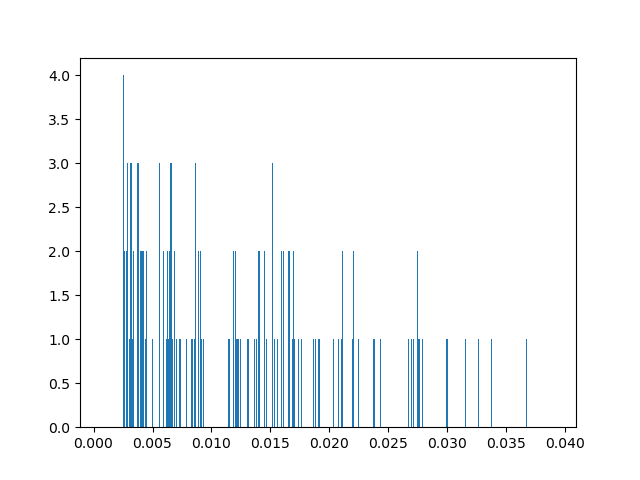

In [145]:
plt.figure()
plt.hist((np.copy(S_conf_intv.T)).flatten(), bins=500)

In [146]:
(np.copy(S_conf_intv.T)).flatten().mean()

0.012543097106964834

INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/polyuq_samp.npz
INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/zetas-0/polyuq_prop.npz
INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/zetas-0/polyuq_sens_var.npz
[0.04314572 0.02621681 0.25045581 0.04326447 0.00542455 0.21119148
 0.00553326 0.0679189  0.25382122] Index(['N_wire', 'dD', 'ice_occ', 'b', 't', 'add_mass', 'A_wire', 'zeta',
       'ice_mass'],
      dtype='object')
INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/polyuq_samp.npz
INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_modal_beam/estimations/zetas-1/polyuq_prop.npz
INFO:uncertainty.polymo

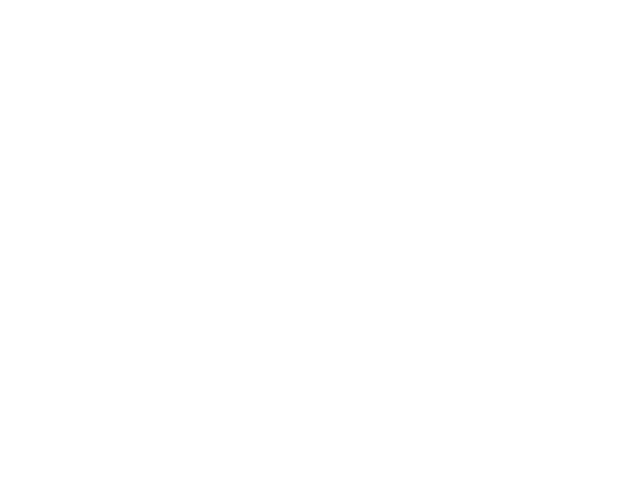

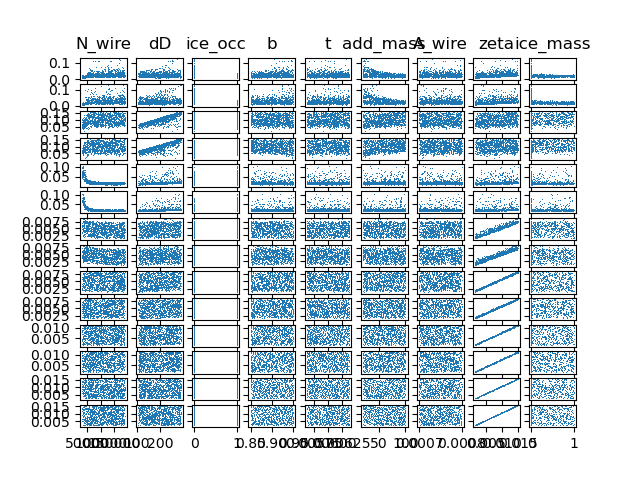

In [47]:
plt.close('all')
ret_name = 'zetas'
meth='var'
# plt.figure()
fig, axes = plt.subplots(14,9, sharex='col',sharey='row')
for mode in range(14):
    
    axes[mode,0].set_ylabel(mode)
    ret_ind = {'modes':mode}
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
    samp_path = os.path.join(result_dir,'polyuq_samp.npz')
    prop_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz')
    sens_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_sens_{meth}.npz')

    poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
    poly_uq.load_state(samp_path, differential='samp')
    poly_uq.load_state(prop_path, differential='prop')
    poly_uq.load_state(sens_path, differential='sens')

    print(poly_uq.S_point, poly_uq.inp_samp_prim.columns)

    self = poly_uq

    vars_epi = self.vars_epi
    vars_ale = self.vars_ale

    N_mcs_ale = self.N_mcs_ale
    N_mcs_epi = self.N_mcs_epi

    inp_samp = self.inp_samp_prim
    out_samp = self.out_samp

    inds_ale, inds_epi = np.mgrid[0:N_mcs_ale, 0:N_mcs_epi]
    inds_ale, inds_epi = inds_ale.ravel(), inds_epi.ravel()

    names_ale = [var.name for var in vars_ale if var.primary]
    names_epi = [var.name for var in vars_epi if var.primary]

    arrays_grid  = [inp_samp[name].iloc[inds_ale] for name in names_ale]
    arrays_grid += [inp_samp[name].iloc[inds_epi] for name in names_epi]

    X = np.array(arrays_grid).T
    Y = out_samp[inds_ale, inds_epi]
    names = names_ale + names_epi

    ind_occ = names.index('ice_occ')
    ind_mass = names.index('ice_mass')
    X[:,ind_mass] *= X[:,ind_occ] 

    ind = np.random.randint(Y.shape[0], size=1000)

    for i in range(len(names)):
        axes[mode,i].plot(X[ind,i], Y[ind], marker=',', ls='none')
for i in range(len(names)):
    axes[0,i].set_title(names[i])